# Dark Souls II Reviews (2025)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import re

## Steam Reviews as of 3/26/25:

In [2]:
df = pd.read_csv('reviews.csv')
reviews = df.copy()
reviews = reviews.set_index('recommendationid')
reviews.drop(columns={'Unnamed: 0', 'in_early_access'}, inplace=True)

Converting date of review from unix:

In [3]:
reviews['month'] = pd.to_datetime(reviews.update_date, unit='s').dt.month_name()
reviews['year'] = pd.to_datetime(reviews.update_date, unit='s').dt.year

Focusing on just the English reviews:

In [4]:
reviews = reviews[reviews.language == 'english']

## EDA:

Distribution of whether or not people recommend buying the game:

In [5]:
recommended_props = reviews[['voted_up']].value_counts(normalize=True).reset_index()

props = alt.Chart(recommended_props).mark_bar().encode(
    alt.X('voted_up', sort=[True, False], axis=alt.Axis(labelAngle=0)).title('Recommeneded'),
    alt.Y('proportion').title('Proportion'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False]),
).properties(
    width=500,
    height=300,
    title="Proportion of people who recommend playing DS2:Scholar of the First Sin (2015-2024)",
).configure_legend(
    titleFontSize=12,
    labelFontSize=12,
) 
props

alt.Chart(...)

- Most people actually recommend the game

Proportions of those who don't and do recommend DS2 in each of the years:

In [6]:
yr_props = reviews.groupby(['year', 'voted_up'])[['review']].count().reset_index()
yr_props['total_reviews'] = yr_props.groupby('year')['review'].transform('sum')
yr_props['proportion'] = yr_props['review'] / yr_props['total_reviews']

yr_count_dist_line = alt.Chart(yr_props).mark_line().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

yr_count_dist_bar = alt.Chart(yr_props).mark_bar().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

(
    (yr_count_dist_line & yr_count_dist_bar)
)

alt.VConcatChart(...)

- Contrary to popular belief, most people actually recommend playing the since its release back in 2015
- Game released    : April 2015 (Scholar of the First Sin edition)
- Amount of reviews during pandemic (2020-2023) was the highest amount for the game ever (at least on Steam exclusively)

## Cleaning up the reviews

In [7]:
reviews = reviews.dropna(subset=['review'])
reviews.shape

(45563, 7)

In [8]:
reviews['review'] = reviews.review.str.lower()

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word.lower() not in stop_words])

In [10]:
reviews['review'] = reviews.review.apply(remove_stopwords)

In [11]:
# Removing urls:
r = [re.sub(r'http\S+', '', review).lower().strip() if pd.notna(review) else review for review in reviews.review]

# Removing esc sequences, punctuation, and numbers:
    # There's some ASCII art in some of the reviews
r = [re.sub(r'[^a-z]', ' ', review).strip() if pd.notna(review) else review for review in r]

In [12]:
# Removing multiple and trailing whitespaces:
r = [re.sub(r' +', ' ', review).strip() if pd.notna(review) else review for review in r]

In [13]:
reviews['review'] = r

In [14]:
reviews

,review,language,init_date,update_date,voted_up,month,year
recommendationid,,,,,,,
190511148,dont give skeleton,english,1742267451,1742267451,True,March,2025
190504311,boia,english,1742259081,1742259081,True,March,2025
190502415,love game pieces s worst souls game ever made ...,english,1742256864,1742256864,True,March,2025
190501465,probably n t recommend awful iron passage frig...,english,1742255757,1742255757,True,March,2025
190500200,peak souls,english,1742254339,1742254339,True,March,2025
...,...,...,...,...,...,...,...
15162268,try tongue hole,english,1427932431,1428081346,True,April,2015
15162220,far good played mins far problems i k r gb gb ...,english,1427932153,1427932153,True,April,2015
15162161,still n t died bonedrinker rufus keep streak a...,english,1427931845,1427931845,True,April,2015


## Sentiment Analysis:
- Seeing why people were positive or negative about the game
    - Comments on story, gameplay, etc

For sake of analysis specifically on the actual reviews, drop any rows that have no reviews:

In [15]:
reviews = reviews.dropna(subset=['review'])
reviews.shape

(45563, 7)

Top 10 Most Common Words in the Reviews:

In [16]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=4000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [18]:
review_txt = reviews.review.values.flatten()
tfidf_array = tfidf.fit_transform(review_txt).toarray()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df.columns = tfidf.get_feature_names_out()

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [19]:
most_unique = tfidf_df.idxmax(axis=1)
top_10 = most_unique.value_counts()[:10]
top_10

aaa      1960
good     1052
best      592
yes       407
dark      309
great     267
nice      252
bad       251
git       235
gud       233
Name: count, dtype: int64

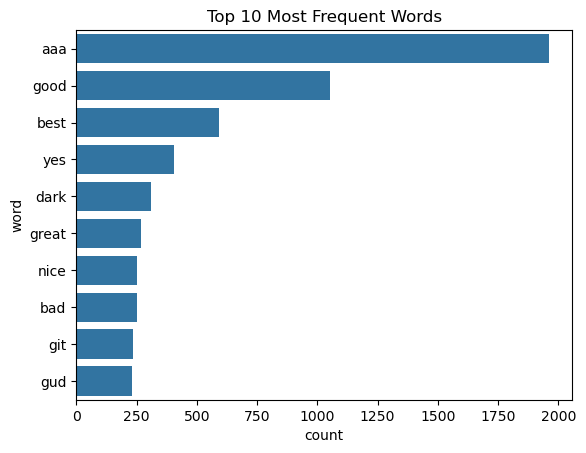

In [20]:
top_10 = top_10.reset_index()
top_10.rename(columns={'index':'word'}, inplace=True)
sns.barplot(data=top_10,
            y='word',
            x='count');
plt.title("Top 10 Most Frequent Words")
plt.show()

- Most popular word w/ semantic meaning: Triple A 
    - def: an informal classification used to classify video games produced and distributed by a mid-sized or major publisher
- Top words used seem to be positive, but this is looking at the words without context

Other popular words:

In [21]:
from wordcloud import WordCloud

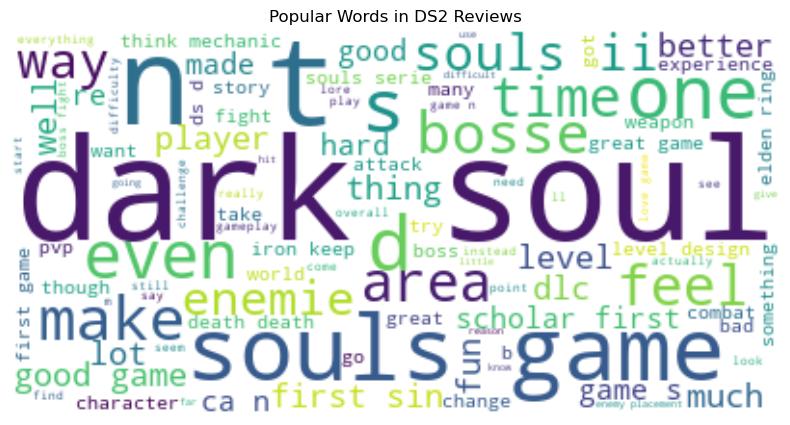

In [22]:
pop_wrds = " ".join( review for review in reviews.review)
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white").generate(pop_wrds)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.title('Popular Words in DS2 Reviews')
plt.show()

- Most common word among the reviews isn't very informative - including some of the other popular words
    - Looking at subsets of the reviews could be useful

### Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews
    
- Algorithms I can use to perform topic modeling:
    1. Latent Dirichlet Allocation (LDA) 
    2. Non-negative Matrix Factorization (NMF)

Splitting the reviews by how many do and don't recommend buying the game:

In [23]:
pos_reviews = reviews[reviews['voted_up'] == True]
neg_reviews = reviews[reviews['voted_up'] == False]

In [24]:
pos_reviews.shape, neg_reviews.shape

((37387, 7), (8176, 7))

Function to display the output of the models:

In [25]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx + 1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx + 1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

LDA: Probabilistic graphical modeling, and uses CountVectorizer as input

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

In [27]:
count_vector = CountVectorizer()

tf = count_vector.fit_transform(reviews.review)
tf_feat_names = count_vector.get_feature_names_out()

pos_tf = count_vector.fit_transform(pos_reviews.review) 
pos_tf_feat_names = count_vector.get_feature_names_out()

neg_tf = count_vector.fit_transform(neg_reviews.review)
neg_tf_feat_names = count_vector.get_feature_names_out()

In [28]:
lda = LatentDirichletAllocation(n_components=3, random_state=42069)
lda.fit(tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [29]:
no_top_words = 10
display_topics(lda, tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,yes,1522.3,game,35415.9,game,21697.9
1,trash,1488.0,ds,14209.2,souls,20165.3
2,die,1388.4,souls,13911.6,dark,14854.9
3,game,1325.2,like,10383.4,good,6485.1
4,get,1154.6,dark,8696.0,best,4494.6
5,gud,1016.8,bosses,6653.4,first,3667.8
6,died,1008.4,one,6286.9,love,3465.1
7,like,926.5,get,6085.3,still,3450.0
8,shit,922.6,enemies,6002.6,games,3381.8
9,would,825.0,even,5723.6,play,2848.6


- Interpreted topics that were identified:
    1. People saying how good the game is
    2. Bosses/enemies
    3. People expressing their likes or dislikes of the game

In [30]:
pos_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
pos_lda.fit(pos_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [31]:
display_topics(pos_lda, pos_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,9274.5,game,31999.1,death,1792.3
1,souls,5176.0,souls,21014.1,yes,1461.8
2,dark,4348.8,dark,13840.7,game,1082.4
3,like,3224.0,good,7840.3,die,970.8
4,ds,3055.0,ds,7528.0,gud,907.9
5,enemies,2870.4,like,5635.7,died,903.6
6,first,2662.6,still,5461.4,get,806.4
7,bosses,2654.0,games,5308.9,git,578.5
8,one,2415.7,best,5232.6,fuck,566.6
9,boss,2405.9,first,4632.0,would,560.6


In [32]:
neg_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
neg_lda.fit(neg_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [33]:
display_topics(neg_lda, neg_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,3751.0,game,11350.1,trash,1098.3
1,bad,888.1,souls,7380.3,game,982.9
2,play,729.8,dark,5076.8,shit,600.2
3,even,611.5,like,3492.6,fucking,493.8
4,pc,567.1,ds,3107.3,play,477.2
5,like,541.1,enemies,2666.8,dont,400.4
6,controls,490.7,one,2162.6,hate,377.1
7,controller,466.0,bosses,2034.7,worst,304.3
8,good,463.4,boss,1907.6,sucks,265.7
9,get,462.9,get,1863.7,fuck,222.8


- Interpreted topics that were identified:
    1. Bosses/enemies
    2. Controls/PC port of the game
    3. Players' comments on that it's the worst Dark Souls game they've played

- Interpreted topics that were identified:
    1. Bosses/enemies
    2. Controls/PC port of the game
    3. Players' comments on that it's the worst Dark Souls game they've played

NMF: Linear algebra and uses the TF-IDF vectorizer as input

In [34]:
from sklearn.decomposition import NMF

In [35]:
nmf = NMF(n_components=3, random_state=42069)
nmf.fit(tfidf_array)

NMF(n_components=3, random_state=42069)

In [36]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,4.5,good,5.3,game,3.3
1,dark,3.7,game,0.7,great,0.9
2,best,2.7,pretty,0.3,ds,0.9
3,ii,0.4,still,0.1,n,0.8
4,games,0.3,really,0.0,like,0.8
5,series,0.3,souls,0.0,fun,0.8
6,better,0.3,actually,0.0,play,0.7
7,still,0.2,yeah,0.0,bad,0.6
8,ever,0.2,luck,0.0,still,0.6
9,worst,0.2,tho,0.0,one,0.5


- Interpreted topics that were identified:
    1. Positive experiences from the game
    2. (similar to 1st topic)
    3. Mixed reception of the game (love and hate)

In [37]:
pos_txt = pos_reviews.review.values.flatten()
pos_tfidf_array = tfidf.fit_transform(pos_txt).toarray()
nmf.fit(pos_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [38]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,souls,4.4,good,5.2,game,3.5
1,dark,3.5,game,0.5,great,1.1
2,best,2.9,pretty,0.3,fun,0.8
3,ii,0.4,still,0.1,ds,0.8
4,games,0.3,souls,0.0,like,0.7
5,series,0.3,really,0.0,n,0.6
6,ever,0.3,actually,0.0,still,0.6
7,better,0.3,yeah,0.0,play,0.6
8,still,0.3,get,0.0,love,0.5
9,one,0.3,dark,0.0,hate,0.5


- Interpreted topics that were identified:
    1. Positive outloooks on the game
    2. similar to 1st topic
    3. People expressing their opinion on the game, ranging from good to bad

In [39]:
neg_txt = neg_reviews.review.values.flatten()
neg_tfidf_array = tfidf.fit_transform(neg_txt).toarray()
nmf.fit(neg_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [40]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,game,1.8,bad,3.3,souls,2.5
1,n,1.0,game,0.7,dark,2.3
2,ds,0.8,really,0.1,worst,0.5
3,like,0.7,design,0.1,play,0.2
4,play,0.7,kinda,0.0,instead,0.2
5,good,0.6,genuinely,0.0,like,0.2
6,one,0.6,souls,0.0,ii,0.2
7,shit,0.5,port,0.0,games,0.2
8,even,0.5,sucks,0.0,series,0.1
9,get,0.5,general,0.0,buy,0.1


- Interpreted topics that were identified:
    1. Vague but concerned w/ enemies
    2. Very negative perspectives on the game
    3. Negative experience regarding bosses, hitboxes, and game design